In [1]:
!pip install transformers

# Imports

In [2]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
from matplotlib import pyplot as plt

# Loading prepared train and test data

In [3]:
data = pd.read_csv('country_wise_train_test.csv')
print(data.shape)
data.head()

(1819, 1582)


,id,overview,budget_unknown,budget_100M,revenue_Argentina_M,revenue_Australia_M,revenue_Austria_M,revenue_Belgium_M,revenue_Domestic_M,revenue_France_M,...,crew_1417400,crew_1421720,crew_1425513,crew_1440737,crew_1455461,crew_1463785,crew_1548698,crew_1552521,crew_1552549,crew_1733142
0,86835,Rick is a screenwriter living in Los Angeles. ...,1,0.00000,0.474532,0.615837,0.445917,0.30037,NaN,2.166664,...,0,0,0,1,0,0,0,0,0,0
1,147441,The defiant leader Moses rises up against the ...,0,1.40000,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,173327,From Bedrooms to Billions is a 2014 documentar...,1,0.00000,NaN,NaN,NaN,NaN,NaN,0.277779,...,0,0,0,0,0,0,0,0,0,0
3,173165,"Starting as a passion project, this movie laun...",0,0.00175,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,155084,"A bright but meek salesman, drowning in debt a...",0,0.05000,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [4]:
COUNTRY = 'United Kingdom'
REVENUE_COL = 'revenue_' + COUNTRY + '_M'

In [5]:
data.dropna(subset=[REVENUE_COL], inplace=True)
data = data[data[REVENUE_COL] > 0]
print(data.shape)

(913, 1582)


In [6]:
data['overview'].fillna('', inplace=True)

In [7]:
# Drop all columns where all values are 0 (cast, crew, etc missing so we can save model training time)
data = data.loc[:, (data != 0).any(axis=0)]
print(data.shape)

(913, 1396)


In [8]:
# Find range of revenue
print(data[REVENUE_COL].describe())

count    913.000000
mean       6.551250
std       14.103521
min        0.000079
25%        0.081300
50%        1.200337
75%        6.378590
max      114.063718
Name: revenue_United Kingdom_M, dtype: float64


In [9]:
# Just a heuristic for scaling the revenue so that mean comes out as 0.5
REVENUE_SCALE = 2 * data[REVENUE_COL].mean()
data[REVENUE_COL] = data[REVENUE_COL] / REVENUE_SCALE

In [10]:
# 2. Dataset and Dataloader
class RevenueDataset(Dataset):
    def __init__(self, tokenizer, data, device, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = data
        self.original_language_cols = [x for x in data.columns if x.startswith('original_language_')]
        self.genre_cols = [x for x in data.columns if x.startswith('genre_')]
        self.cast_cols = [x for x in data.columns if x.startswith('cast_')]
        self.crew_cols = [x for x in data.columns if x.startswith('crew_')]
        self.device = device

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inputs = self.tokenizer.encode_plus(row['overview'], add_special_tokens=True, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt').to(self.device)

        original_language = torch.tensor(row[self.original_language_cols].values.astype(float), dtype=torch.float, device=self.device)
        genres = torch.tensor(row[self.genre_cols].values.astype(float), dtype=torch.float, device=self.device)
        cast = torch.tensor(row[self.cast_cols].values.astype(float), dtype=torch.float, device=self.device)
        crew = torch.tensor(row[self.crew_cols].values.astype(float), dtype=torch.float, device=self.device)
        budget = torch.tensor(row['budget_100M'], dtype=torch.float, device=self.device)
        budget_unknown = torch.tensor(row['budget_unknown'], dtype=torch.float, device=self.device)
        revenue = torch.tensor(row[REVENUE_COL], dtype=torch.float, device=self.device)

        x = torch.cat((
            inputs["input_ids"].squeeze(),
            inputs["attention_mask"].squeeze(),
            original_language,
            genres,
            cast,
            crew,
            budget.unsqueeze(0),
            budget_unknown.unsqueeze(0)
        ))

        return x, revenue

    def __len__(self):
      return len(self.data)

In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
BATCH_SIZE = 16

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
DATASET = RevenueDataset(tokenizer, data, DEVICE)
train_dataset, test_dataset = torch.utils.data.random_split(DATASET, [int(len(DATASET)*0.8), len(DATASET) - int(len(DATASET)*0.8)], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
NUM_GENRES = len(DATASET.genre_cols)
NUM_CAST = len(DATASET.cast_cols)
NUM_CREW = len(DATASET.crew_cols)
NUM_ORIGINAL_LANGUAGES = len(DATASET.original_language_cols)
print(NUM_GENRES, NUM_CAST, NUM_CREW, NUM_ORIGINAL_LANGUAGES)

20 892 429 34


In [16]:
# 3. Model
class RevenuePredictor(nn.Module):
    def __init__(self, bert_embedding_size = 128, cast_embedding_size = 32, crew_embedding_size = 32, hidden_size = 128):
        super(RevenuePredictor, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")

        # Linear layer for textual embeddings
        self.linear_overview = nn.Linear(self.bert.config.hidden_size, bert_embedding_size)

        # # Linear layer for original language embeddings
        # self.linear_original_language = nn.Linear(NUM_ORIGINAL_LANGUAGES, original_language_embedding_size)

        # Linear layer for embedding cast
        self.linear_cast = nn.Linear(NUM_CAST, cast_embedding_size)

        # Linear layer for embedding crew
        self.linear_crew = nn.Linear(NUM_CREW, crew_embedding_size)

        # Budget and budget_unknown, and genres
        self.other_features_size = 2 + NUM_GENRES + NUM_ORIGINAL_LANGUAGES

        self.output_layer = nn.Sequential(
            nn.Linear(bert_embedding_size + cast_embedding_size + crew_embedding_size + self.other_features_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, input):
        bert_out = self.bert(input_ids=input[:, :256].long(), attention_mask=input[:, 256:512].long())
        overview_embedding = self.linear_overview(bert_out['pooler_output'])
        overview_embedding = nn.LeakyReLU()(overview_embedding)

        original_language = input[:, 512:512+NUM_ORIGINAL_LANGUAGES]
        cast_embedding = self.linear_cast(input[:, 512+NUM_ORIGINAL_LANGUAGES:512+NUM_ORIGINAL_LANGUAGES+NUM_CAST])
        cast_embedding = nn.LeakyReLU()(cast_embedding)
        crew_embedding = self.linear_crew(input[:, 512+NUM_ORIGINAL_LANGUAGES+NUM_CAST:512+NUM_ORIGINAL_LANGUAGES+NUM_CAST+NUM_CREW])
        cast_embedding = nn.LeakyReLU()(cast_embedding)
        other_features = input[:, 512+NUM_ORIGINAL_LANGUAGES+NUM_CAST+NUM_CREW:]


        return self.output_layer(torch.cat((
            overview_embedding,
            original_language,
            cast_embedding,
            crew_embedding,
            other_features
        ), dim=1))

In [17]:
model = RevenuePredictor(bert_embedding_size=256, hidden_size=256, cast_embedding_size=32, crew_embedding_size=16)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [18]:
NUM_BATCHES = len(train_dataloader)
NUM_EPOCHS = 10
print("Number of batches: ", NUM_BATCHES)
print("Number of epochs: ", NUM_EPOCHS)

Number of batches:  46
Number of epochs:  10


In [19]:
optimizer = AdamW(model.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
SCHEDULER_STEPS = NUM_BATCHES * NUM_EPOCHS
SCHEDULER_WARMUP_STEPS = 250
print("Scheduler steps: ", SCHEDULER_STEPS)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=250, num_training_steps=SCHEDULER_STEPS)

Scheduler steps:  460


In [21]:
model.to(DEVICE)

RevenuePredictor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [22]:
best_mse = float('inf')
best_weights = None
history = []

In [23]:
MODEL_PATH = 'model_' + COUNTRY + '.pth'

In [24]:
for epoch in range(NUM_EPOCHS):
    model.train()
    loop = tqdm(train_dataloader)
    loop.set_description(f"Epoch {epoch + 1}")
    for x, y in loop:
        optimizer.zero_grad()

        predictions = model(x)
        loss = loss_fn(predictions, y.unsqueeze(1))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        loop.set_postfix(mseloss=loss.item())

    # Evaluate on test set
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for x, y in test_dataloader:
            predictions = model(x)
            preds.extend(predictions.squeeze().tolist())
            actuals.extend(y.tolist())
    mse = loss_fn(torch.tensor(preds).unsqueeze(1), torch.tensor(actuals).unsqueeze(1)).item()
    print("MSE on test set after epoch ", epoch + 1, ": ", mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        torch.save(model.state_dict(), MODEL_PATH)

Epoch 1: 100%|██████████| 46/46 [00:37<00:00,  1.23it/s, mseloss=0.45]


MSE on test set after epoch  1 :  0.7550745606422424


Epoch 2: 100%|██████████| 46/46 [00:33<00:00,  1.39it/s, mseloss=0.207]


MSE on test set after epoch  2 :  0.7543796300888062


Epoch 3: 100%|██████████| 46/46 [00:33<00:00,  1.36it/s, mseloss=0.388]


MSE on test set after epoch  3 :  0.7546667456626892


Epoch 4: 100%|██████████| 46/46 [00:34<00:00,  1.35it/s, mseloss=4.21]


MSE on test set after epoch  4 :  0.7459003329277039


Epoch 5: 100%|██████████| 46/46 [00:33<00:00,  1.36it/s, mseloss=0.515]


MSE on test set after epoch  5 :  0.919344961643219


Epoch 6: 100%|██████████| 46/46 [00:34<00:00,  1.35it/s, mseloss=0.22]


MSE on test set after epoch  6 :  0.7644566893577576


Epoch 7: 100%|██████████| 46/46 [00:33<00:00,  1.36it/s, mseloss=3.06]


MSE on test set after epoch  7 :  0.8305438160896301


Epoch 8: 100%|██████████| 46/46 [00:33<00:00,  1.36it/s, mseloss=0.0856]


MSE on test set after epoch  8 :  0.7738622426986694


Epoch 9: 100%|██████████| 46/46 [00:33<00:00,  1.36it/s, mseloss=0.157]


MSE on test set after epoch  9 :  0.7802022099494934


Epoch 10: 100%|██████████| 46/46 [00:33<00:00,  1.35it/s, mseloss=1.21]


MSE on test set after epoch  10 :  0.7809982895851135


In [25]:
# Print history
print(history)
print("Best model saved at ", MODEL_PATH, " with MSE ", best_mse, ". MAKE SURE TO DOWNLOAD!")

[0.7550745606422424, 0.7543796300888062, 0.7546667456626892, 0.7459003329277039, 0.919344961643219, 0.7644566893577576, 0.8305438160896301, 0.7738622426986694, 0.7802022099494934, 0.7809982895851135]
Best model saved at  model_United Kingdom.pth  with MSE  0.7459003329277039 . MAKE SURE TO DOWNLOAD!


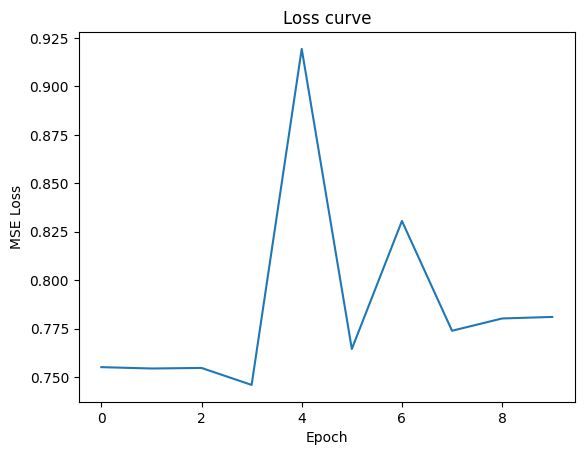

In [26]:
# Plot loss history
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss curve')
plt.show()

In [27]:
print("Scale the predictions by ", REVENUE_SCALE, " to get the predicted revenue in Millions")

Scale the predictions by  13.102500591456735  to get the predicted revenue in Millions
